本教程包括三部分内容：多层感知机中常用的激活函数，利用张量计算底层方法实现多层感知机，以及利用PyTorch神经网络模块实现多层感知机。


## 一、多层感知机中常用的激活函数

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys

Text(0, 0.5, 'relu(x)')

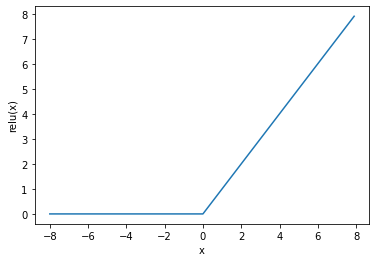

In [2]:
#relu(x)
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
plt.plot(x.detach().numpy(),y.detach().numpy())
plt.xlabel('x')
plt.ylabel('relu(x)')

Text(0, 0.5, 'grad of relu(x)')

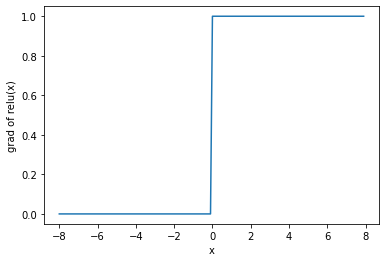

In [3]:
#grad of relu(x)
y.sum().backward()
plt.figure() #新图窗
plt.plot(x.detach().numpy(),x.grad.detach().numpy())
plt.xlabel('x')
plt.ylabel('grad of relu(x)')

Text(0, 0.5, 'sigmoid(x)')

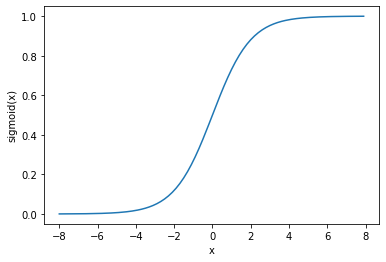

In [4]:
#sigmoid(x)
y=x.sigmoid()
#sigmoid函数在早期的神经网络中应用较为普遍，但它目前逐渐被更简单的ReLU函数取代。
#当输入接近0时，sigmoid函数接近于线性变换。
plt.plot(x.detach().numpy(),y.detach().numpy())
plt.xlabel('x')
plt.ylabel('sigmoid(x)')

Text(0, 0.5, 'grad of sigmoid(x)')

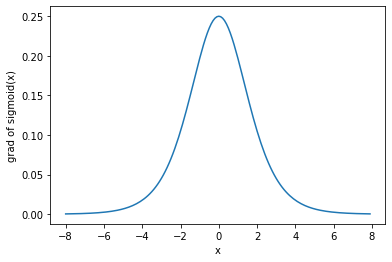

In [5]:
#grad of sigmoid(x)
#当输入为0时，sigmoid函数的导数达到最大值0.25；当输入越偏离0时，sigmoid函数的导数越接近0。
x.grad.zero_() #清空x的梯度
y.sum().backward()
plt.figure() #新图窗
plt.plot(x.detach().numpy(),x.grad.detach().numpy())
plt.xlabel('x')
plt.ylabel('grad of sigmoid(x)')

Text(0, 0.5, 'tanh(x)')

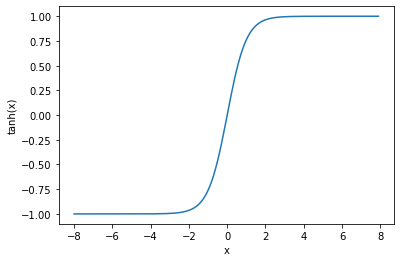

In [6]:
#tanh(x)
#当输入接近0时，tanh函数接近线性变换。
#虽然该函数的形状和sigmoid函数的形状很像，但tanh函数在坐标系的原点上对称。
y=x.tanh()
plt.plot(x.detach().numpy(),y.detach().numpy())
plt.xlabel('x')
plt.ylabel('tanh(x)')

Text(0, 0.5, 'grad of tanh(x)')

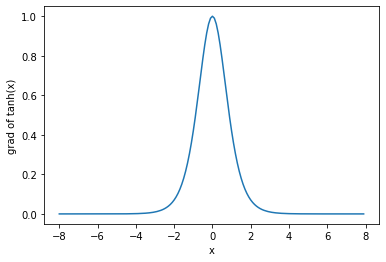

In [7]:
#grad of tanh(x)
#当输入为0时，tanh函数的导数达到最大值1；当输入越偏离0时，tanh函数的导数越接近0。
x.grad.zero_() #清空x的梯度
y.sum().backward()
plt.figure() #新图窗
plt.plot(x.detach().numpy(),x.grad.detach().numpy())
plt.xlabel('x')
plt.ylabel('grad of tanh(x)')

## 二、多层感知机的实现——基于张量计算的底层方法

In [8]:
import torchvision
import torchvision.transforms as transforms
import time

多层感知机的实现包括装载数据、模型设计、训练与测试。

### 装载数据

我们以FashionMNIST数据集为例，请尝试运行下面的代码。如果运行失败，可查看下方的替代解决方案。

In [9]:
mnist_train = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=True, download=True,transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=False, download=True,transform=transforms.ToTensor())

如果因为网络等原因，上面的代码运行失败的话，可以采用手动下载数据的替代解决方案。<br>
可以下载 https://cloud.tsinghua.edu.cn/d/81061a7a0529455e8552/ 中的processed文件夹，替换掉上面代码运行失败但仍然生成了的./Datasets/FashionMNIST/FashionMNIST/processed文件夹，之后运行下面的代码：

In [10]:
mnist_train = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=True, download=False,transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=False, download=False,transform=transforms.ToTensor())

上面的mnist_train和mnist_test都是torch.utils.data.Dataset的子类，所以我们可以用len()来获取该数据集的大小，还可以用下标来获取具体的一个样本。训练集中和测试集中的每个类别的图像数分别为6,000和1,000。因为有10个类别，所以训练集和测试集的样本数分别为60,000和10,000。

In [11]:
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

torchvision.datasets.mnist.FashionMNIST
60000 10000


我们可以通过下标来访问任意一个样本:

In [12]:
feature, label = mnist_train[0]
print(feature.shape, label)  # Channel x Height x Width

torch.Size([1, 28, 28]) 9


变量feature对应高和宽均为28像素的图像。由于我们使用了transforms.ToTensor()，所以每个像素的数值为[0.0, 1.0]的32位浮点数。需要注意的是，feature的尺寸是 (C x H x W) 的，而不是 (H x W x C)。第一维是通道数，因为数据集中是灰度图像，所以通道数为1。后面两维分别是图像的高和宽。

Fashion-MNIST中一共包括了10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数可以将数值标签转成相应的文本标签。

In [13]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

下面定义一个可以在一行里画出多张图像和对应标签的函数。

In [14]:
from IPython import display
display.set_matplotlib_formats('svg')

In [15]:
def show_fashion_mnist(images, labels):
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

我们查看一下训练数据集中前10个样本的图像内容和文本标签。

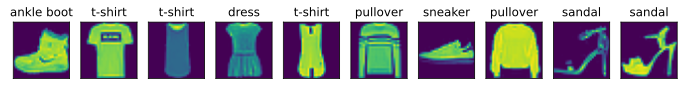

In [16]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

我们将在训练数据集上训练模型，并将训练好的模型在测试数据集上评价模型的表现。前面说过，mnist_train是torch.utils.data.Dataset的子类，所以我们可以将其传入torch.utils.data.DataLoader来创建一个读取小批量数据样本的DataLoader实例。

In [17]:
#读取数据
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=256, shuffle=True)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=256, shuffle=False)

DataLoader函数是PyTorch的重要工具。建议大家到PyTorch官方文档中对这这个函数做一定了解（也即了解PyTorch加载数据的方法）。
https://pytorch.org/docs/stable/data.html#module-torch.utils.data

### 模型设计

定义模型参数：Fashion-MNIST数据集中图像形状为 28×28，类别数为10。本节中我们依然使用长度为28×28=784的向量表示每一张图像。因此，输入个数为784，输出个数为10。模型超参数隐含层节点个数设为256。

In [18]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)

params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

定义激活函数: 这里我们使用基础的max函数来实现ReLU，而非直接调用PyTorch中的relu函数。

In [19]:
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

定义模型：我们通过view函数将每张原始图像改成长度为num_inputs的向量，之后实现多层感知机的计算表达式。

In [20]:
def net(X):
    X = X.view((-1, num_inputs))
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

定义损失函数：为了得到更好的数值稳定性，我们直接使用PyTorch提供的包括softmax运算和交叉熵损失计算的函数。

In [21]:
loss = torch.nn.CrossEntropyLoss()

### 训练模型

定义一个训练函数

In [22]:
def train(net, train_iter, test_iter, loss, num_epochs, params, lr):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, test_acc_sum,n_train,n_test = 0.0, 0.0,0.0, 0,0
        for X, y in train_iter:
            #X是当前批次的训练数据，y是对应的标签
            y_hat = net(X)
            l = loss(y_hat, y).sum()

            # 梯度清零
            
            if params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()

            #误差反向传播
            l.backward()

            #小批量梯度下降算法
            if params[0].grad is not None:
                for param in params:
                    param.data -= lr * param.grad # 注意这里更改param时用的param.data

            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item() #统计训练集识别正确的样本数
            n_train += y.shape[0] #统计训练集样本总数
            
        for X_test,y_test in test_iter:
            #x_test是测试数据，y_test是对应的标签
            test_acc_sum += (net(X_test).argmax(dim=1) == y_test).sum().item() #统计测试集识别正确的样本数
            n_test += y_test.shape[0] #统计测试集样本总数
        
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n_train, train_acc_sum / n_train, test_acc_sum / n_test)) #输出结果


In [23]:
num_epochs, lr = 5, 0.5
train(net, train_iter, test_iter, loss, num_epochs, params, lr)

epoch 1, loss 0.0032, train acc 0.696, test acc 0.779
epoch 2, loss 0.0020, train acc 0.816, test acc 0.824
epoch 3, loss 0.0017, train acc 0.842, test acc 0.797
epoch 4, loss 0.0015, train acc 0.855, test acc 0.839
epoch 5, loss 0.0015, train acc 0.863, test acc 0.823


### 三、利用PyTorch神经网络模块实现多层感知机

上面给出的是一个基于张量计算的较为底层的实现。下面更充分地利用PyTorch提供的神经网络模块功能，给出一个较为简洁的实现。

In [24]:
from torch import nn
from torch.nn import init

In [25]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

#定义一个数据形状转换的层
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): 
        return x.view(x.shape[0], -1)
    
net = nn.Sequential(
        FlattenLayer(), #Flatten
        nn.Linear(num_inputs, num_hiddens), #784->256
        nn.ReLU(), #Relu
        nn.Linear(num_hiddens, num_outputs), #256->10
        )

for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

上面的训练函数是自己定义了优化方式。实际上可以直接采用PyTorch提供的优化器。我们稍作修改，重新定义一个训练函数。

In [26]:
def train_with_opt(net, train_iter, test_iter, loss, num_epochs,optimizer):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, test_acc_sum,n_train,n_test = 0.0, 0.0,0.0, 0,0
        for X, y in train_iter:
            #X是当前批次的训练数据，y是对应的标签
            y_hat = net(X)
            l = loss(y_hat, y).sum()

            # 梯度清零
            optimizer.zero_grad()
            
            #误差反向传播
            l.backward()
            
            #利用梯度下降法更新模型参数
            optimizer.step()

            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item() #统计训练集识别正确的样本数
            n_train += y.shape[0] #统计训练集样本总数
            
        for X_test,y_test in test_iter:
            #x_test是测试数据，y_test是对应的标签
            test_acc_sum += (net(X_test).argmax(dim=1) == y_test).sum().item() #统计测试集识别正确的样本数
            n_test += y_test.shape[0] #统计测试集样本总数
        
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n_train, train_acc_sum / n_train, test_acc_sum / n_test)) #输出结果

开始训练

In [27]:
batch_size = 256

train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=256, shuffle=True)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=256, shuffle=False)

loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=0.5)

num_epochs = 5

train_with_opt(net, train_iter, test_iter, loss, num_epochs, optimizer)

epoch 1, loss 0.0031, train acc 0.700, test acc 0.794
epoch 2, loss 0.0019, train acc 0.815, test acc 0.814
epoch 3, loss 0.0017, train acc 0.842, test acc 0.812
epoch 4, loss 0.0015, train acc 0.857, test acc 0.826
epoch 5, loss 0.0015, train acc 0.864, test acc 0.854


如果有支持CUDA的显卡GPU (Graphics Processing Unit) 硬件，可以尝试在GPU上进行训练。CUDA是Compute Unified Device Architecture (统一计算架构)的缩写，是Nvidia公司推出的一套在该公司特定系列的GPU上进行并行计算的编程环境，包括显卡驱动，sdk，toolkit等。目前主流的深度学习框架通常采用 CUDA 进行 GPU 并行加速。NVIDIA 还推出了专门用于深度学习的并行计算加速库cuDNN。

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
device

'cuda'

如果显示设备支持cuda，可以尝试把模型放到GPU上训练。

In [30]:
if torch.cuda.is_available():
    model=net.cuda()
loss=loss.to('cpu')

In [31]:
def train_with_cuda(net, train_iter, test_iter, loss, num_epochs,optimizer):
    if torch.cuda.is_available():
        for epoch in range(num_epochs):
            train_l_sum, train_acc_sum, test_acc_sum,n_train,n_test = 0.0, 0.0,0.0, 0,0
            for X, y in train_iter:
                #X是当前批次的训练数据，y是对应标签
                X=X.cuda() #数据也要移到cuda上
                y=y.cuda()
                y_hat = net(X)
                l = loss(y_hat, y).sum()

                # 梯度清零
                optimizer.zero_grad()
            
                #误差反向传播
                l.backward()
            
                #利用梯度下降法更新模型参数
                optimizer.step()

                train_l_sum += l.item()
                train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item() #统计训练集识别正确的样本数
                n_train += y.shape[0] #统计训练集样本总数
            
            for X_test,y_test in test_iter:
                #X_test是测试数据，y_test是对应的标签
                X_test=X_test.cuda()
                y_test=y_test.cuda()
                test_acc_sum += (net(X_test).argmax(dim=1) == y_test).sum().item() #统计测试集识别正确的样本数
                n_test += y_test.shape[0] #统计测试集样本总数
        
            print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
                  % (epoch + 1, train_l_sum / n_train, train_acc_sum / n_train, test_acc_sum / n_test)) #输出结果

In [32]:
if torch.cuda.is_available():
    train_with_cuda(model, train_iter, test_iter, loss, num_epochs, optimizer)

epoch 1, loss 0.0014, train acc 0.871, test acc 0.824
epoch 2, loss 0.0013, train acc 0.877, test acc 0.856
epoch 3, loss 0.0013, train acc 0.881, test acc 0.842
epoch 4, loss 0.0012, train acc 0.883, test acc 0.862
epoch 5, loss 0.0012, train acc 0.888, test acc 0.845


对于已训练好的模型，可以保存模型，并在后续读取模型，进行测试，也可以根据需要在其他数据集上继续训练。

In [33]:
#保存模型
if torch.cuda.is_available():
    torch.save(model.state_dict(),"model.pth")
else:
    torch.save(net.state_dict(),"model.pth")

In [34]:
#定义模型并读取模型参数
net_new = nn.Sequential(
        FlattenLayer(), #Flatten
        nn.Linear(num_inputs, num_hiddens), #784->256
        nn.ReLU(), #Relu
        nn.Linear(num_hiddens, num_outputs), #256->10
        )
net_new.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [36]:
#使用读取的模型做预测
if torch.cuda.is_available():
    x, y = mnist_test[0][0].cuda(), mnist_test[0][1]
else:
    x, y = mnist_test[0][0], mnist_test[0][1]
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat','sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
with torch.no_grad():
    if torch.cuda.is_available():
        pred = model(x)
    else:
        pred = net(x)
    predicted, actual = text_labels[pred[0].argmax(0)], text_labels[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "ankle boot", Actual: "ankle boot"
